In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12, 9)

# Image Alignment

## Image Transformations

In class we covered how to apply projective transformations to images and how to estimate the transformation between images. In this notebook we will focus on applying transformations to images. Image alignment and stitching will be covered in assignment 2.

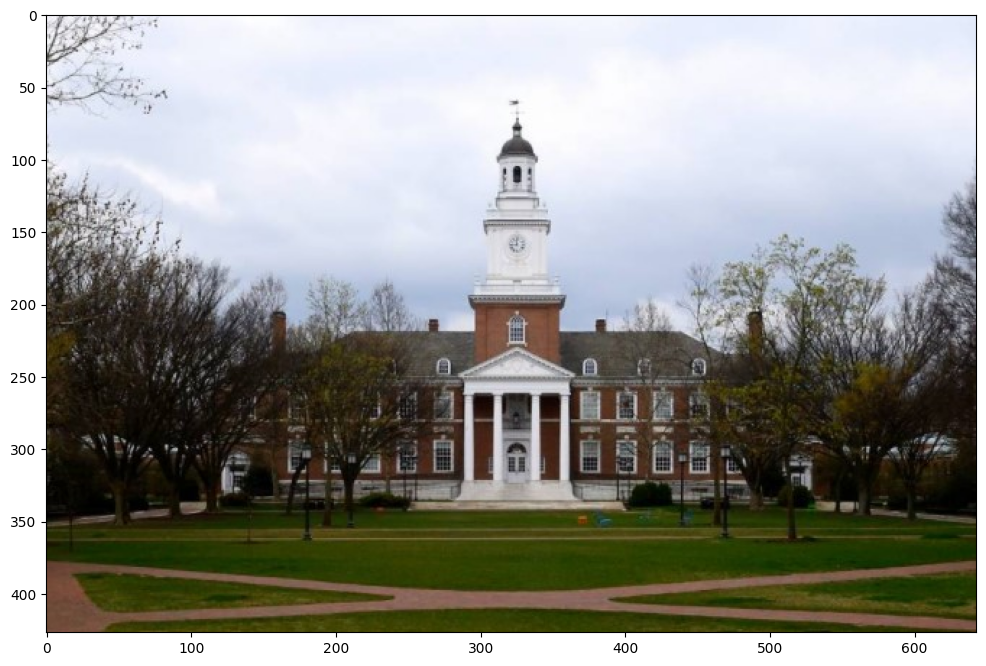

In [2]:
image = cv2.imread('data/gilman.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape
plt.figure()
plt.imshow(image)
plt.show()

Recall from class that we can represent transformations using matrices. Since we are operating in 2D with homogeneous coordinates, every linear transformation can be represented as a 3x3 matrix.

(2 points) In the cell below, create a 3x3 matrix that represents a scaling of 0.5 in the x-dimension. Apply it to the image using `cv2.warpPerspective()` and plot the result. Carefully set the output image size so there is no blank space in the output.

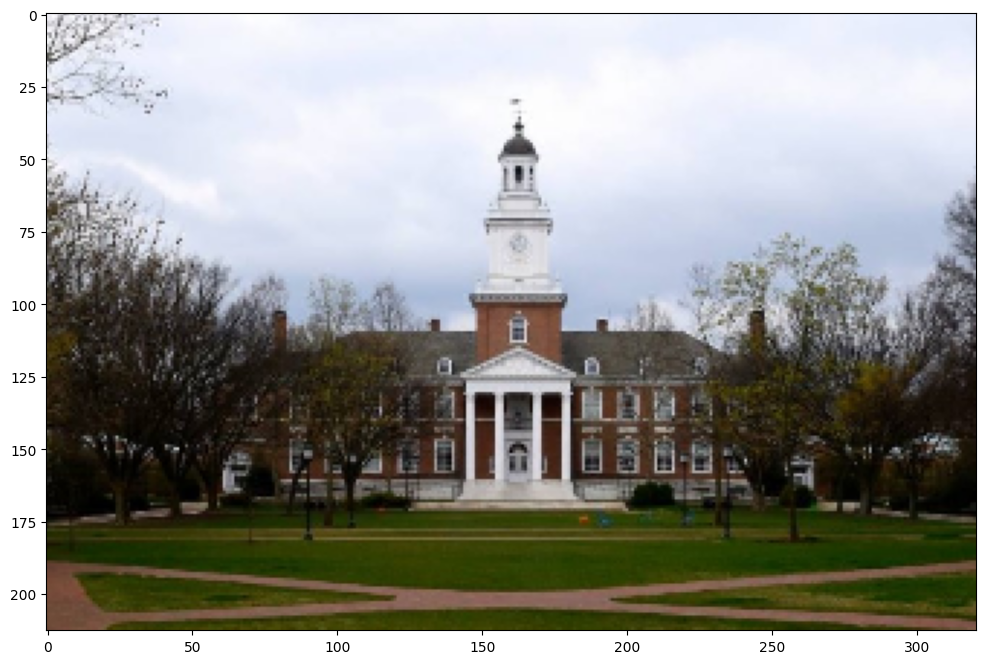

In [3]:
transform = np.array([[0.5, 0, 0], [0, 0.5, 0], [0, 0, 1]])
output = cv2.warpPerspective(image, transform, (width//2, height//2))

plt.imshow(output)
plt.show()

(2 points) Now, create a 3x3 matrix representing a rotation by 30 degrees counterclockwise. Apply this to the image using `warpPerspective()`, with output size being the same as the original image size. Display the result.

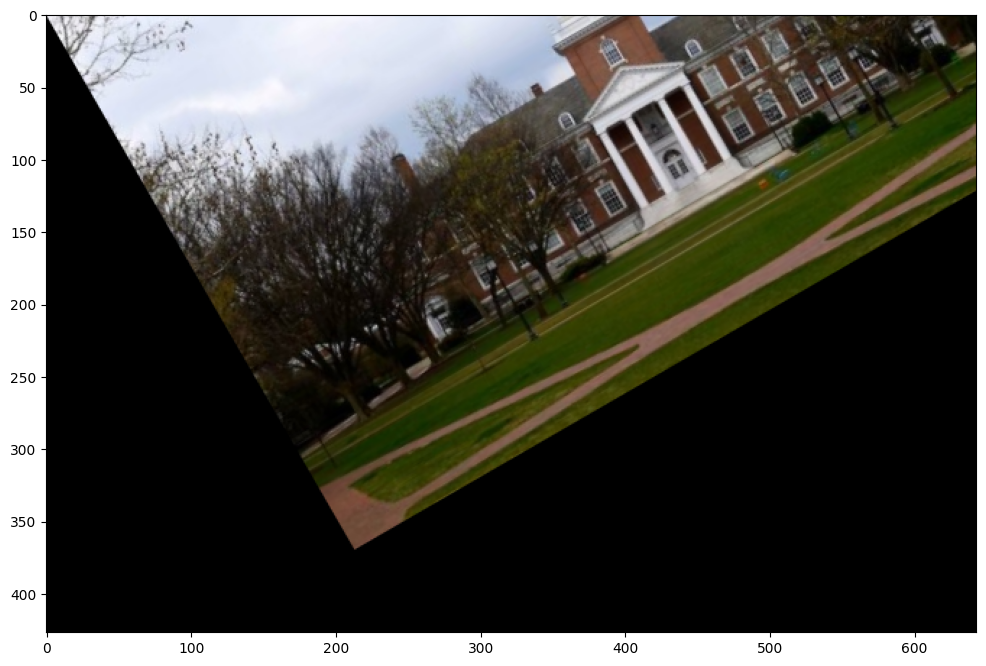

In [4]:
theta = -np.pi/6
rotation = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
output = cv2.warpPerspective(image, rotation, (width, height))

plt.imshow(output)
plt.show()

You might notice that part of the image is clipped by the boundary of the new image. In the cell below, create a new transformtation matrix that rotates the image the same way (30 degrees counterclockwise), but resulting in an output image that contains the entirety of the original image like the figure below:

![](resources/rot30.png)

Hints:
- You should be able to achieve this by simply shifting the result in the last step.
- You can decide how much to shift by looking at where the corners of the original image are mapped to.
- Transformation composition can be implemented as matrix multiplication.
- Carefully choose the output size.

(5 points) Complete the cell below, print the matrix and plot the output image.

[[  0.8660254   0.5         0.       ]
 [ -0.5         0.8660254 321.       ]
 [  0.          0.          1.       ]]


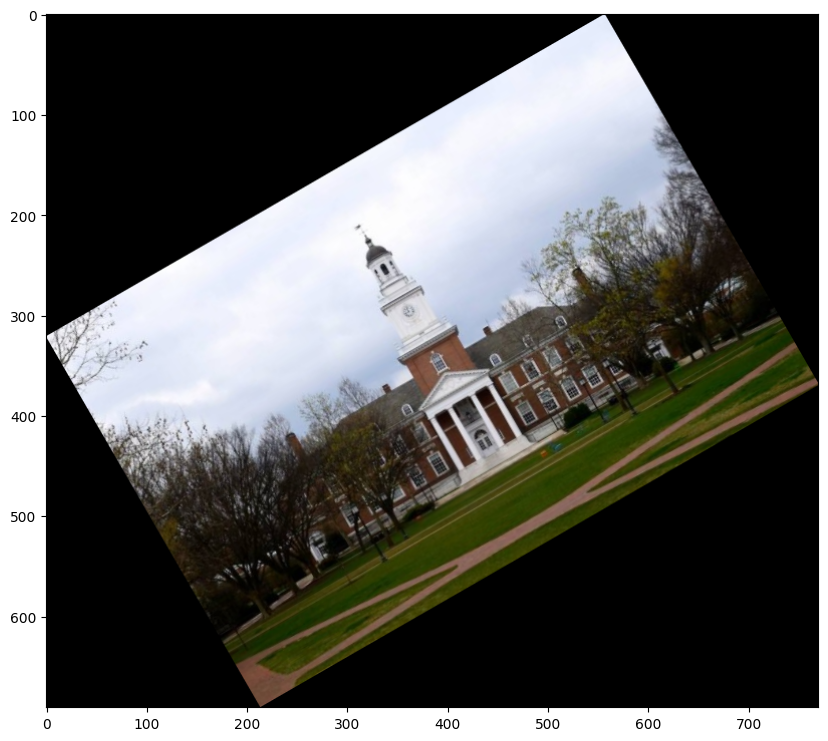

In [7]:
corners = np.array([
    [0, width, width, 0],
    [0, 0, height, height],
    [1, 1, 1, 1]]
)

new_corners = rotation @ corners
left = int(np.round(np.min(new_corners[0])))
right = int(np.round(np.max(new_corners[0])))
top = int(np.round(np.min(new_corners[1])))
bottom = int(np.round(np.max(new_corners[1])))

new_width = right - left
new_height = bottom - top

dx = np.max([0, -left])
dy = np.max([0, -top])
shift = np.array([[1, 0, dx], [0, 1, dy], [0, 0, 1]])
new_transform = shift @ rotation

output = cv2.warpPerspective(image, new_transform, (new_width, new_height))
print(new_transform)

plt.imshow(output)
plt.show()

## Forward and Backward Warping

Let's see how the warping function can be implemented. The most straightforward way to do this is to send the values of each pixel in the source image to the corresponding position in the target image. In class we termed this "forward warping".

(3 points) In the cell below, implement forward mapping and plot the result.

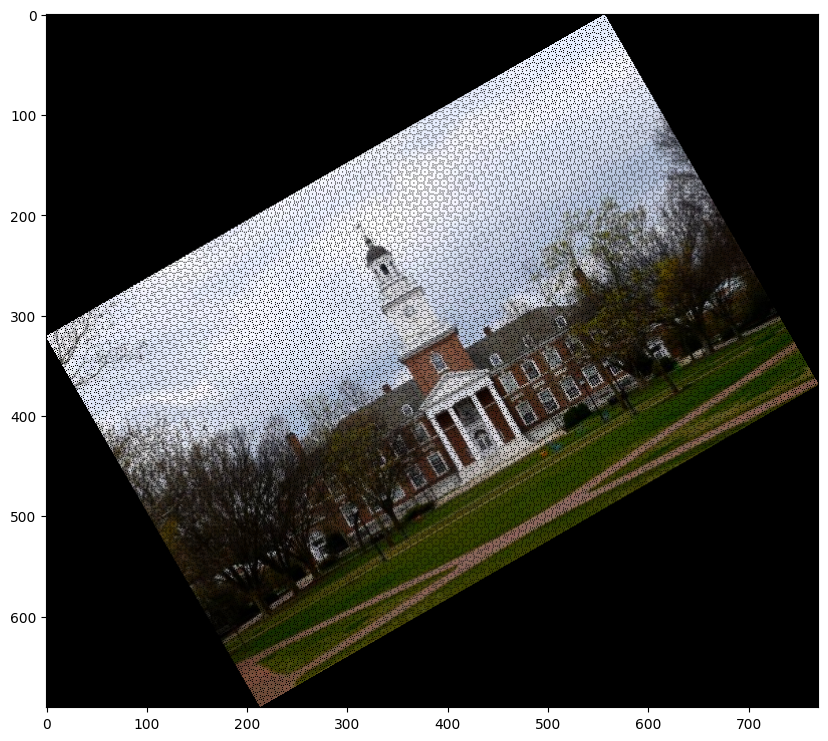

In [10]:
output_img = np.zeros((new_height, new_width, 3), dtype=np.uint8)
for i in range(width):
    for j in range(height):
        ret = new_transform
        x,y,_ = ret @ np.array([i, j, 1]).T
        x = int(np.round(x))
        y = int(np.round(y))
        if x >= 0 and x < new_width and y >= 0 and y < new_height:
            output_img[y, x] = image[j, i]

plt.imshow(output_img)
plt.show()

The output should roughly look like what you got from `cv2.warpPerspective()`. However, you may find that there are lots of artifacts on the output image. This is because when we "send" source pixels to target pixels, not every target pixel is guaranteed to "receive" a source pixel.

(3 points) It is a better idea to do the warping backwards. In other words, for every pixel in the output image, we find the corresponding location in the source image. Complete the cell below to implement backward warping and plot the result.

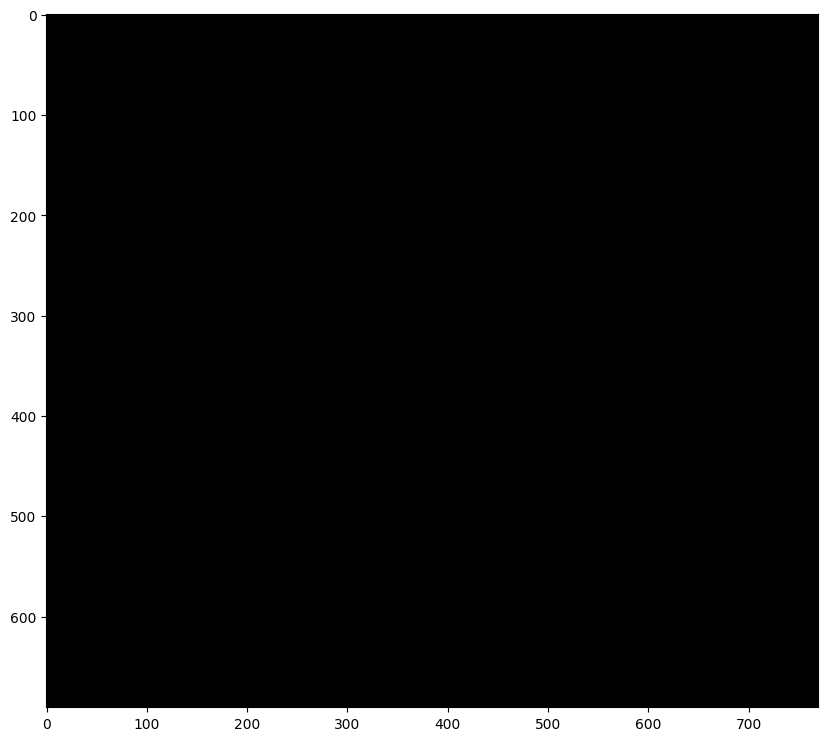

In [12]:
inv_transform = np.linalg.inv(new_transform)
output_img = np.zeros((new_height, new_width, 3), dtype=np.uint8)
for i in range(new_width):
    for j in range(new_height):
        ret = inv_transform @ np.array([i, j, 1]).T
        i,j,_ = ret.flatten()
        i = int(np.round(i))
        j = int(np.round(j))
        if i >= 0 and i < width and j >= 0 and j < height:
            output_img[y, x] = image[j, i]


plt.imshow(output_img)
plt.show()